# Polystyrene Mastercurve (Oscillation)

Fit polystyrene mastercurve data with GM and fractional models.

**Data:** examples/data/mastercurves/master_curve_ps_oscillation_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell
from rheojax.models import HerschelBulkley

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


## Load mastercurve data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm = FractionalMaxwellModel()
fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
fm_pred = fm.predict(omega, test_mode='oscillation')
fm_r2 = r2_complex(G_star, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.926474s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=1.926s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.470483s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.470s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.305602s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=36 | final_cost=3.9375e+10 | elapsed=1.306s | final_gradient_norm=1.7507e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.594593s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=1.595s | final_gradient_norm=0.0065


{'gm_r2': 0.9996658397874467, 'fm_r2': 0.28487891403164944}


## Plot fits

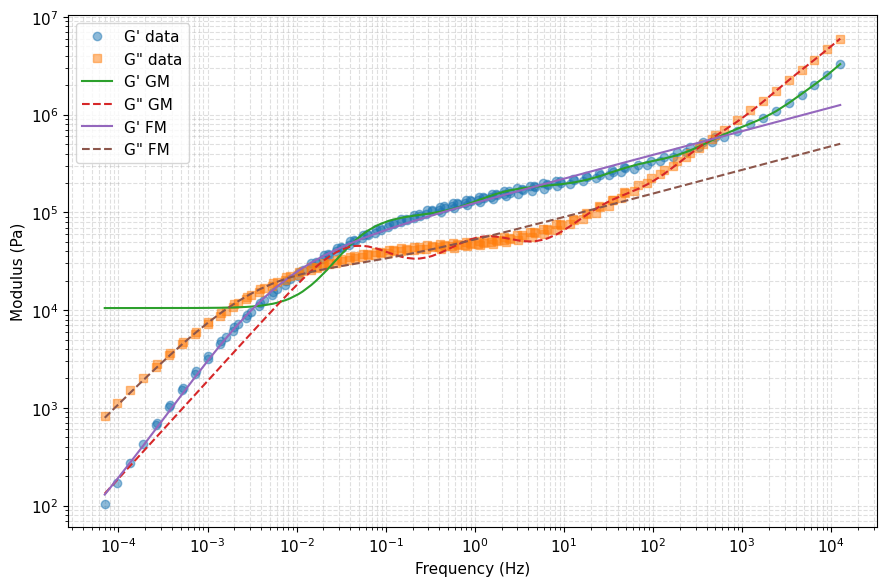

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.582010s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.582s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.459031s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=1.8809e+10 | elapsed=0.459s | final_gradient_norm=3.0251e+07


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.437294s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=36 | final_cost=3.9375e+10 | elapsed=0.437s | final_gradient_norm=1.7507e+17


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.452729s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=0.453s | final_gradient_norm=0.0065


Dataset 0 ranking: [('fm', 0.285)]


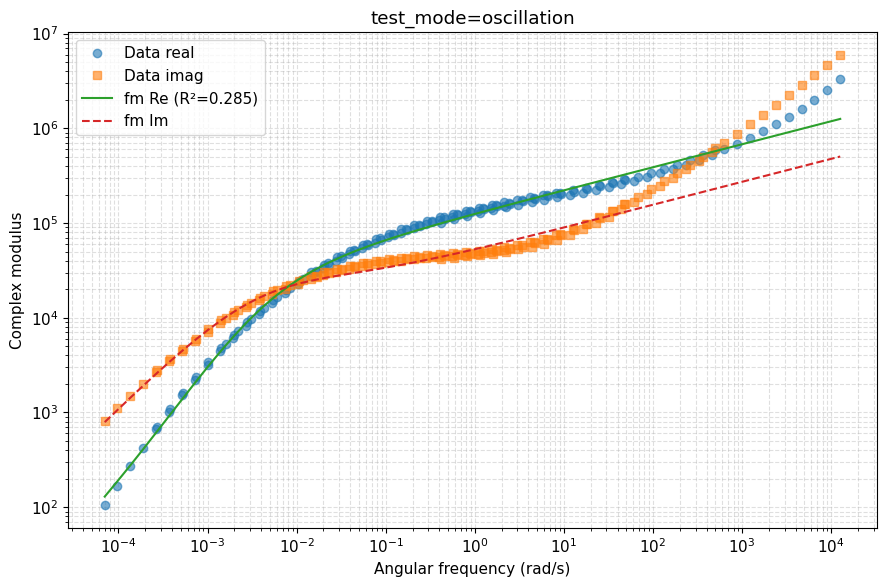

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:25,  2.63it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   6%|▌         | 42/700 [00:00<00:06, 109.22it/s, 1023 steps of size 6.74e-04. acc. prob=0.90]

warmup:   9%|▉         | 63/700 [00:00<00:09, 68.65it/s, 1023 steps of size 6.87e-04. acc. prob=0.92] 

warmup:  11%|█         | 77/700 [00:01<00:09, 64.85it/s, 255 steps of size 7.84e-04. acc. prob=0.93] 

warmup:  13%|█▎        | 88/700 [00:01<00:10, 58.71it/s, 1023 steps of size 6.89e-04. acc. prob=0.93]

warmup:  14%|█▍        | 97/700 [00:01<00:09, 62.54it/s, 511 steps of size 4.66e-04. acc. prob=0.93] 

warmup:  15%|█▌        | 106/700 [00:01<00:09, 64.46it/s, 511 steps of size 5.93e-03. acc. prob=0.94]

warmup:  17%|█▋        | 116/700 [00:01<00:08, 69.34it/s, 1023 steps of size 4.48e-03. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [00:01<00:08, 69.01it/s, 1023 steps of size 3.64e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:02<00:08, 70.03it/s, 1023 steps of size 4.22e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:02<00:08, 69.74it/s, 511 steps of size 4.15e-03. acc. prob=0.95] 

warmup:  21%|██▏       | 149/700 [00:02<00:08, 63.46it/s, 1023 steps of size 3.91e-03. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [00:02<00:08, 64.98it/s, 1023 steps of size 1.70e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [00:02<00:08, 64.14it/s, 1023 steps of size 1.77e-03. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [00:02<00:08, 64.18it/s, 423 steps of size 1.52e-03. acc. prob=0.95] 

warmup:  25%|██▌       | 178/700 [00:02<00:08, 62.50it/s, 767 steps of size 1.99e-03. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [00:02<00:08, 61.35it/s, 1023 steps of size 2.33e-03. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [00:03<00:08, 60.93it/s, 1023 steps of size 1.95e-03. acc. prob=0.95]

warmup:  28%|██▊       | 199/700 [00:03<00:08, 62.06it/s, 695 steps of size 1.92e-03. acc. prob=0.96] 

sample:  30%|██▉       | 209/700 [00:03<00:07, 69.48it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  31%|███       | 217/700 [00:03<00:06, 70.66it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  32%|███▏      | 225/700 [00:03<00:07, 67.02it/s, 767 steps of size 1.94e-03. acc. prob=0.98] 

sample:  33%|███▎      | 232/700 [00:03<00:07, 61.52it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  34%|███▍      | 239/700 [00:03<00:07, 61.55it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [00:03<00:07, 61.71it/s, 63 steps of size 1.94e-03. acc. prob=0.98]  

sample:  36%|███▌      | 253/700 [00:03<00:07, 61.37it/s, 191 steps of size 1.94e-03. acc. prob=0.98]

sample:  37%|███▋      | 260/700 [00:04<00:07, 60.84it/s, 399 steps of size 1.94e-03. acc. prob=0.98]

sample:  38%|███▊      | 267/700 [00:04<00:07, 58.86it/s, 199 steps of size 1.94e-03. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [00:04<00:07, 54.99it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  40%|████      | 280/700 [00:04<00:07, 55.92it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  41%|████      | 286/700 [00:04<00:07, 55.67it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [00:04<00:07, 54.23it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [00:04<00:07, 54.51it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  44%|████▎     | 306/700 [00:04<00:06, 60.65it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  45%|████▍     | 313/700 [00:05<00:06, 60.09it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  46%|████▌     | 320/700 [00:05<00:06, 58.81it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  47%|████▋     | 326/700 [00:05<00:07, 51.20it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  47%|████▋     | 332/700 [00:05<00:07, 48.90it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  48%|████▊     | 338/700 [00:05<00:07, 50.49it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  49%|████▉     | 344/700 [00:05<00:07, 50.68it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  50%|█████     | 350/700 [00:05<00:06, 51.13it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  51%|█████     | 356/700 [00:05<00:06, 52.88it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  52%|█████▏    | 362/700 [00:05<00:06, 52.37it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  53%|█████▎    | 368/700 [00:06<00:06, 52.76it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  53%|█████▎    | 374/700 [00:06<00:06, 52.40it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  55%|█████▍    | 382/700 [00:06<00:05, 57.22it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  56%|█████▌    | 389/700 [00:06<00:05, 59.85it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  57%|█████▋    | 398/700 [00:06<00:04, 65.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  58%|█████▊    | 405/700 [00:06<00:04, 62.80it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  59%|█████▉    | 412/700 [00:06<00:04, 63.02it/s, 511 steps of size 1.94e-03. acc. prob=0.98] 

sample:  60%|█████▉    | 419/700 [00:06<00:04, 61.42it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  61%|██████    | 426/700 [00:07<00:04, 58.71it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  62%|██████▏   | 432/700 [00:07<00:05, 53.50it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  63%|██████▎   | 438/700 [00:07<00:04, 53.84it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  63%|██████▎   | 444/700 [00:07<00:04, 55.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  64%|██████▍   | 451/700 [00:07<00:04, 57.30it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  65%|██████▌   | 458/700 [00:07<00:04, 59.17it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  66%|██████▋   | 465/700 [00:07<00:03, 61.17it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  67%|██████▋   | 472/700 [00:07<00:03, 59.55it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  68%|██████▊   | 478/700 [00:07<00:04, 54.47it/s, 511 steps of size 1.94e-03. acc. prob=0.98] 

sample:  69%|██████▉   | 486/700 [00:08<00:03, 59.27it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  70%|███████   | 493/700 [00:08<00:03, 54.59it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  71%|███████▏  | 499/700 [00:08<00:03, 55.59it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  72%|███████▏  | 505/700 [00:08<00:03, 53.98it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  73%|███████▎  | 511/700 [00:08<00:03, 54.58it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  74%|███████▍  | 517/700 [00:08<00:03, 55.21it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  75%|███████▍  | 523/700 [00:08<00:03, 55.04it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  76%|███████▌  | 530/700 [00:08<00:02, 57.49it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  77%|███████▋  | 536/700 [00:09<00:02, 57.58it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  78%|███████▊  | 543/700 [00:09<00:02, 59.08it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  79%|███████▊  | 551/700 [00:09<00:02, 64.63it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  80%|███████▉  | 558/700 [00:09<00:02, 65.51it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  81%|████████  | 565/700 [00:09<00:02, 65.30it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  82%|████████▏ | 572/700 [00:09<00:01, 64.64it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [00:09<00:01, 63.71it/s, 903 steps of size 1.94e-03. acc. prob=0.98] 

sample:  84%|████████▎ | 586/700 [00:09<00:01, 62.34it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  85%|████████▌ | 595/700 [00:09<00:01, 68.90it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  86%|████████▌ | 602/700 [00:09<00:01, 65.69it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  87%|████████▋ | 609/700 [00:10<00:01, 62.43it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  88%|████████▊ | 616/700 [00:10<00:01, 60.80it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  89%|████████▉ | 624/700 [00:10<00:01, 63.93it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  90%|█████████ | 631/700 [00:10<00:01, 65.08it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  91%|█████████ | 638/700 [00:10<00:00, 62.31it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  92%|█████████▏| 645/700 [00:10<00:00, 63.20it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  93%|█████████▎| 652/700 [00:10<00:00, 63.07it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  94%|█████████▍| 659/700 [00:10<00:00, 60.35it/s, 767 steps of size 1.94e-03. acc. prob=0.98] 

sample:  95%|█████████▌| 666/700 [00:11<00:00, 56.88it/s, 1023 steps of size 1.94e-03. acc. prob=0.98]

sample:  96%|█████████▌| 673/700 [00:11<00:00, 58.82it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [00:11<00:00, 61.16it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [00:11<00:00, 62.69it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [00:11<00:00, 62.18it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:11<00:00, 60.32it/s, 1023 steps of size 1.94e-03. acc. prob=0.99]

Dataset 0: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)